In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [30]:
!python3 -m pip install imbalanced-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn]


In [31]:
# Load dataset
df = pd.read_csv("/Users/lucky/Downloads/insurance_data.csv")


In [32]:
# Rename columns to lowercase for consistency
df.columns = df.columns.str.lower()


In [33]:
# Print column names to verify correct names
print("Dataset Columns:", df.columns) 


Dataset Columns: Index(['index', 'patientid', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')


In [34]:
# Check for missing values
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


In [36]:
# Handle categorical missing values safely
df = df.copy()
if 'diabetic' in df.columns and not df['diabetic'].dropna().empty:
    df['diabetic'] = df['diabetic'].fillna(df['diabetic'].mode()[0])
else:
    df['diabetic'] = df['diabetic'].astype(str).fillna("Unknown")

if 'smoker' in df.columns and not df['smoker'].dropna().empty:
    df['smoker'] = df['smoker'].fillna(df['smoker'].mode()[0])
else:
    df['smoker'] = df['smoker'].astype(str).fillna("Unknown")



In [37]:
# Generate Fraud Labels (Example: Claims above 95th percentile are fraud)
if 'claim' not in df.columns:
    raise KeyError("Column 'claim' not found. Available columns: ", df.columns)
threshold = df['claim'].quantile(0.95)  # Top 5% as fraud
df['fraud'] = np.where(df['claim'] > threshold, 1, 0)


In [38]:
# Define features and target
df['diabetic'] = df['diabetic'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
df['smoker'] = df['smoker'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
X = df[['diabetic', 'children', 'smoker', 'claim']].copy()


In [39]:
# Ensure no NaN values remain in the feature set
print("Missing values before training:", X.isna().sum())
X = X.fillna(X.median())
print("Missing values after handling:", X.isna().sum())

y = df['fraud']


Missing values before training: diabetic    0
children    0
smoker      0
claim       0
dtype: int64
Missing values after handling: diabetic    0
children    0
smoker      0
claim       0
dtype: int64


In [40]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# Address class imbalance using RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Before resampling:", y_train.value_counts())
print("After resampling:", y_resampled.value_counts())

# Train model on balanced data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)



Before resampling: fraud
0    1025
1      47
Name: count, dtype: int64
After resampling: fraud
0    1025
1    1025
Name: count, dtype: int64


RandomForestClassifier(random_state=42)

In [42]:
# Predictions
y_pred = model.predict(X_test)


In [43]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00        20

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



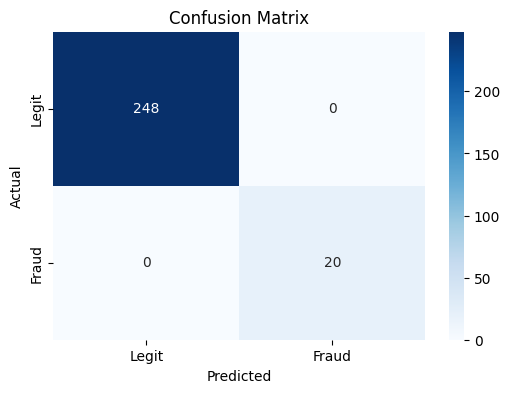

In [44]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


/var/folders/kk/v32_wv2s1pq0r3wjf9wm0nhm0000gn/T/ipykernel_1216/3605197720.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['fraud'], palette='coolwarm')


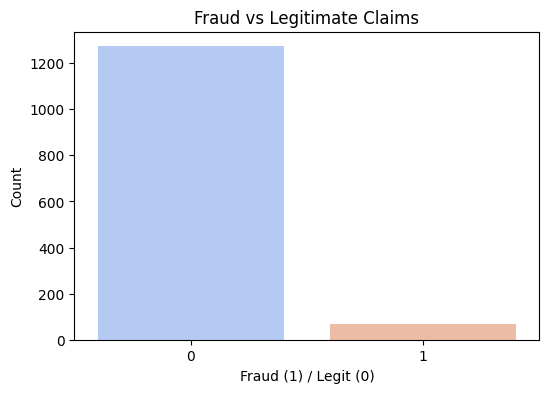

In [45]:
# Fraud distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['fraud'], palette='coolwarm')
plt.title("Fraud vs Legitimate Claims")
plt.xlabel("Fraud (1) / Legit (0)")
plt.ylabel("Count")
plt.show()


In [46]:
dump(model, 'insurance_fraud_model.joblib')
print("Model saved as 'insurance_fraud_model.joblib'")

Model saved as 'insurance_fraud_model.joblib'


In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from joblib import load, dump  # For saving/loading models

# --- Load or Train the Model ---
model = load('insurance_fraud_model.joblib')

# --- Prediction Function ---
def predict_fraud():
    print("\n🔍 Enter the following details to predict insurance claim fraud:")
    
    # Input for diabetic status
    while True:
        diabetic = input("Is the patient diabetic? (Yes/No/Unknown): ").strip().lower()
        diabetic_map = {'yes': 1, 'no': 0, 'unknown': -1}
        if diabetic in diabetic_map:
            diabetic_encoded = diabetic_map[diabetic]
            break
        print("❌ Invalid input. Please enter 'Yes', 'No', or 'Unknown'.")
    
    # Input for number of children
    while True:
        try:
            children = int(input("Number of children: "))
            if children >= 0:
                break
            else:
                print("❌ Number of children cannot be negative.")
        except ValueError:
            print("❌ Invalid input. Please enter a whole number (e.g., 0, 1, 2).")
    
    # Input for smoker status
    while True:
        smoker = input("Is the patient a smoker? (Yes/No/Unknown): ").strip().lower()
        smoker_map = {'yes': 1, 'no': 0, 'unknown': -1}
        if smoker in smoker_map:
            smoker_encoded = smoker_map[smoker]
            break
        print("❌ Invalid input. Please enter 'Yes', 'No', or 'Unknown'.")
    
    # Input for claim amount
    while True:
        try:
            claim = float(input("Claim amount ($): "))
            if claim >= 0:
                break
            else:
                print("❌ Claim amount cannot be negative.")
        except ValueError:
            print("❌ Invalid input. Please enter a number (e.g., 5000.50).")
    
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'diabetic': [diabetic_encoded],
        'children': [children],
        'smoker': [smoker_encoded],
        'claim': [claim]
    })
    
    # Make prediction
    prediction = model.predict(input_data)
    
    # Display result
    if prediction[0] == 1:
        print("\n🚨 Prediction: Fraudulant Claim")
    else:
        print("\n✅ Prediction: Legitimate Claim")

# --- Run the Predictor ---
if __name__ == "__main__":
    predict_fraud()


🔍 Enter the following details to predict insurance claim fraud:

🚨 Prediction: Fraudulant Claim
